
# Capstone Project - Auto Ticket Assignment to the right IT Functional Groups
Capstone Project - Auto Ticket Assignment to the right IT Functional Groups

## Key Steps:
### Data Collection and Analysis
### Data Pre-processing
### Data Preparation
### Model

# Install necessary packages

In [3]:
 !pip install fuzzywuzzy

In [4]:
# !pip install nltk
!pip install contractions

     |████████████████████████████████| 317kB 4.5MB/s 
     |████████████████████████████████| 245kB 8.4MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81692 sha256=6709ccf30502607d0f396e389130205bed431b0bd27683705679699791d5d074
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


# Import Libraries

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Numerical libraries
import numpy as np   
# to handle data in form of rows and columns 
import pandas as pd    
# importing ploting libraries
import matplotlib.pyplot as plt   

#importing seaborn for statistical plots
import seaborn as sns
import string
from fuzzywuzzy import fuzz

import os

In [7]:
from keras.utils import to_categorical
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, BatchNormalization,SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.stats import zscore

Using TensorFlow backend.


In [8]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
import string
import contractions
from sklearn.model_selection import train_test_split
from collections import OrderedDict

from wordcloud import WordCloud, STOPWORDS # this module is for making wordcloud in python

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Mount Drive and Load data file

In [9]:
# mount google drive

from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
#Set your project path 

filePath = '/gdrive/My Drive/Colab Notebooks/Capstone/'
fileName = filePath + 'Input Data Synthetic.xlsx'

In [0]:
# reading the xlsx file into pandas dataframe
data_df = pd.read_excel(fileName,index_col= None)  

### Salient Features of the Data,

- Data is highly imbalanced between Group-0 and rest of the Assignment Groups
- Short Description and Description columns will be making the Corpus of the Model
- Data seems to be a free text and does not have defined structure or format
- Similar text content in the incidents is assigned to multiple Assignment Groups in few cases
- One of the observations is that Large set of incidents are generated by same Caller
- The Callers are free to create incidents in any Language and hence we can find roughly 8 to 10% of incidents in languages other than English
- Large set of incidents are auto generated by the digital robot and do have same text content with Job Scheduler Id, Date, time stamp etc.


# Exploratory Data Analysis

In [12]:
# display firt 5 data samples
data_df.head(5)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [13]:
# summary of descriptive statistics that summarize the central tendency.
data_df.describe().transpose()

,count,unique,top,freq
Short description,8492,7481,password reset,38
Description,8499,7817,the,56
Caller,8500,2950,bpctwhsn kzqsbmtp,810
Assignment group,8500,74,GRP_0,3976


In [0]:
# Align datafrme columns
data_df.columns=['Short_description', 'Description', 'Caller', 'Assignment_group']

In [15]:
# Display data types and all the columns are of type object as they contain text in each column
data_df.dtypes

Short_description    object
Description          object
Caller               object
Assignment_group     object
dtype: object

In [16]:
# Display the null values in the data samples
# Short description has 8 null records
# description has 1 null record

data_df.isnull().sum()

Short_description    8
Description          1
Caller               0
Assignment_group     0
dtype: int64

### Observations
- The Assignment Group column is the target variable and classes among which the incidents will be assigned
- The dataset has total of 8500 samples.
- The 8500 records are distributed across 73 Assignment groups
- Almost 50% of samples belong to one Assignment Group (Group-0) and this means data imbalance between the class
- Few of the Assignment groups 5 to 1 samples and these groups will impact the performance of the Model big time
- As depicted in the Visualisation-1 in section 5, the data is skewed and there is high imbalance between assignment groups (target classes). 
- 3976 incidents were assigned to Assignment Group-0 and this is majority group
- There are two groups with only 1 record of data sample 

- Data is highly imbalanced between Group-0 and Rest of the Assignment Groups
- Data imbalance will be impacting the Model performance and it will be biased towards majority classes 

 

# Feature Engineering

In [17]:
# Data sampling with Replacement
# Used Sklearn Utils Resample
# Up-Sampling the Minority groups
# tested the model with tuning the value count parameter and works better

from sklearn.utils import resample

data_majority = data_df[data_df['Assignment_group'].isin(data_df['Assignment_group'].value_counts()[data_df['Assignment_group'].value_counts() > 70].index)]
data_minority = data_df[data_df['Assignment_group'].isin(data_df['Assignment_group'].value_counts()[data_df['Assignment_group'].value_counts() < 70].index)]

print(data_majority.shape)
# print(data_minority.shape)

data_minority_upsampled = resample(data_minority,
                                 replace=True,    
                                 n_samples=len(data_majority),
                                #  stratify=True,
                                 random_state=123)

print(data_minority_upsampled.shape)

data_upsampled = pd.concat([data_minority_upsampled, data_majority])
#data_upsampled['Assignment_group'].value_counts()
print(data_upsampled.shape)

(7481, 4)
(7481, 4)
(14962, 4)


In [0]:
# Copy the upsampled data set into original data frame
data_df = data_upsampled.copy()

In [0]:
# Replace Nan values in Short_description and Description to THE - since this stop word will be eliminated in the vectorization
data_df.Description.fillna("The", inplace=True)
data_df.Short_description.fillna("The", inplace=True)

In [0]:
# Drop the rows that have null values in Assignment Groups
data_df = data_df.dropna(subset=["Assignment_group"])

In [0]:
# Drop the Caller Column
data_df = data_df.drop(['Caller'], 1)

In [0]:
# Insert 2 new Columns for Fuzzy Rating and Combined Description

data_df.insert(3, 'fuzzy_Rating', '0')
data_df.insert(4, 'Combined_Description', '0')

In [23]:
# Display top 5 records after upsampling

data_df.head(5)

,Short_description,Description,Assignment_group,fuzzy_Rating,Combined_Description
4561,zcor0003; variants plant_271 and rodstock not ...,zcor0003; variants plant_271 and rodstock not ...,GRP_44,0,0
3422,please include purchase group in pr to po anal...,please include field to enter aqzz/erpquery/me...,GRP_20,0,0
3590,full access to oe drive fÃ¼rth,\r\n\r\nreceived from: scjxobhd.ldypjkmf@gmail...,GRP_34,0,0
3120,ç”µè„‘ç¡¬ç›˜æ•…éšœï¼Œè¯·æ±‚ç»´ä¿®ã€‚,ç”µè„‘ç¡¬ç›˜æ•…éšœï¼Œè¯·æ±‚ç»´ä¿®ã€‚,GRP_30,0,0
8247,computer network connection lost,computer network connection lost,GRP_31,0,0


In [0]:
# Calcuate the Fuzzy Rating for each row between Short Description and Description

for i in data_df.index:
  data_df.fuzzy_Rating[i] = fuzz.ratio(str(data_df.values[i][0]),str(data_df.values[i][1]))

In [0]:
# Combine Description and Short Description text based on the Fuzzy Rating

for i in data_df.index:
    if data_df.fuzzy_Rating[i] is 100:
      data_df.Combined_Description[i] = str(data_df.Short_description[i])
    else:
      data_df.Combined_Description[i] = str(data_df.Short_description[i]) + str(data_df.Description[i])

In [26]:
# Display top 5 records to see the new columns

data_df.head()

,Short_description,Description,Assignment_group,fuzzy_Rating,Combined_Description
4561,zcor0003; variants plant_271 and rodstock not ...,zcor0003; variants plant_271 and rodstock not ...,GRP_44,21,4561 zcor0003; variants plant_271 and rodst...
3422,please include purchase group in pr to po anal...,please include field to enter aqzz/erpquery/me...,GRP_20,5,3422 please include purchase group in pr to...
3590,full access to oe drive fÃ¼rth,\r\n\r\nreceived from: scjxobhd.ldypjkmf@gmail...,GRP_34,9,3590 full access to oe drive fÃ¼rth\n3590 ...
3120,ç”µè„‘ç¡¬ç›˜æ•…éšœï¼Œè¯·æ±‚ç»´ä¿®ã€‚,ç”µè„‘ç¡¬ç›˜æ•…éšœï¼Œè¯·æ±‚ç»´ä¿®ã€‚,GRP_30,32,3120 ç”µè„‘ç¡¬ç›˜æ•…éšœï¼Œè¯·æ±‚ç»´ä¿®ã€‚\n...
8247,computer network connection lost,computer network connection lost,GRP_31,100,8247 computer network connection lost \n824...


In [27]:
# Handling punctuations

cd = [""]
for combinedDescription in data_df.Combined_Description:
    cd.append(combinedDescription)

cdToStr = ' '.join([str(elem) for elem in cd])

punc = ""
for i in cdToStr:        
  if i in string.punctuation:
    punc = punc + i + ","

puncList = punc.split(',')
print("Unique Punctuations in data are : ", np.unique(puncList))

Unique Punctuations in data are :  ['' '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' '-' '.' '/' ':' ';' '<'
 '=' '>' '?' '@' '[' '\\' ']' '^' '_' '`' '{' '|' '}' '~']


In [0]:
# Initialise the Stemming and Lemmitization functions

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

In [0]:
# Derive and Insert new column to store number of Digits in each row

data_df["Desc_1_ndigits"] = data_df["Combined_Description"].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

In [0]:
# Derive and Insert new column to store number of Word Count in each row

data_df["Desc_1_count"] = data_df["Combined_Description"].apply(lambda x: len(str(x).split(" ")))

In [0]:
# Derive and store more frequent words in an array

description_most_freq_words = pd.Series(" ".join(data_df["Combined_Description"]).split()).value_counts()

In [0]:
### Least frequent words in description
description_least_freq_words =  pd.Series(" ".join(data_df["Combined_Description"]).split()).value_counts().sort_values(ascending = True)

In [0]:
### Most frequent words in description
description_1_most_freq_words = pd.Series(" ".join(data_df["Combined_Description"]).split()).value_counts()

In [34]:
# Display number of digits vs combined description column
data_df[["Combined_Description","Desc_1_ndigits"]].sort_values(by = "Desc_1_ndigits",ascending = False).head()

,Combined_Description,Desc_1_ndigits
7345,security incidents - ( sw #in33501789 ) : broa...,457
4089,security incidents - ( sw #in33895560 ) : mage...,444
3706,security incidents - ( #in33924718 ) : possibl...,156
3965,security incidents - ( #in33809307 ) : possibl...,154
3961,security incidents - ( #in33805815) : possible...,153


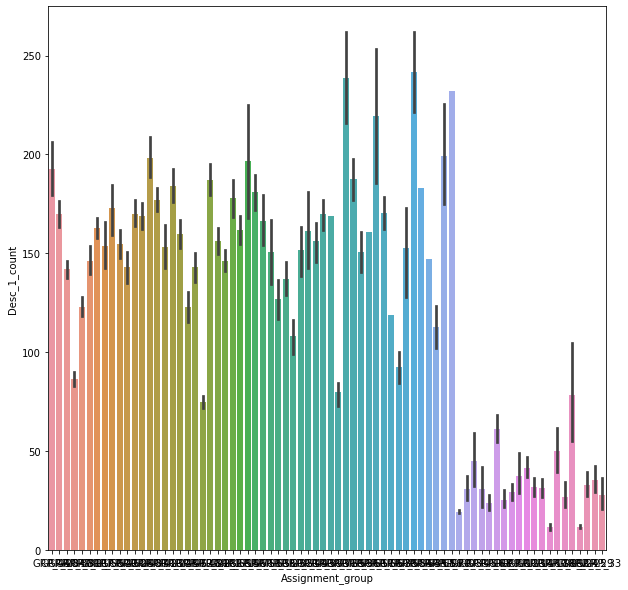

In [35]:
# Plot grah to show the word count by Assignment groups

plt.figure(figsize=(10,10))
sns.barplot(x=data_df['Assignment_group'],y=data_df['Desc_1_count'],data=data_df)

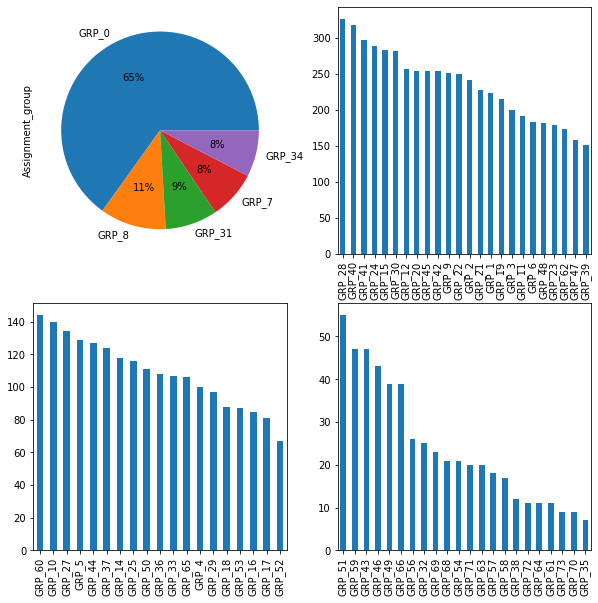

In [36]:
# Plot graphs to visualize the word count by Assignment groups in to 4 sections
# sectoin 1 between 0 to 5 top count
# sectoin 2 between 6 to 30 top count
# sectoin 3 between 31 to 50 top count
# sectoin 2 between 51 to 73 top count

fig,axs = plt.subplots(2,2, sharex=False, figsize=(10,10))

data_df['Assignment_group'].value_counts()[0:5].plot(kind='pie', autopct='%1.0f%%', ax=axs[0, 0])
data_df['Assignment_group'].value_counts()[6:30].plot(kind='bar', ax=axs[0, 1])
data_df['Assignment_group'].value_counts()[31:50].plot(kind='bar', ax=axs[1, 0])
data_df['Assignment_group'].value_counts()[51:73].plot(kind='bar', ax=axs[1, 1])

plt.show()

# Observations
- As there is no relation between Caller column and the other columns, the caller column is dropped.
- As both short description and description have similar or same text in many cases, we used a package named fuzzywuzzy and its function to identify the fuzzy score (by comparing the words in two strings). 
- If the two strings (short description and description) are same, the score will be very high, and a conditional statement is applied not to merge / concatenate the columns and take only one of the two column values. If the fuzzy score is less, then both the texts are concatenated. 
- This is the method used to build the corpus (Combination of Short Description & description). 


### Word Cloud before data processing

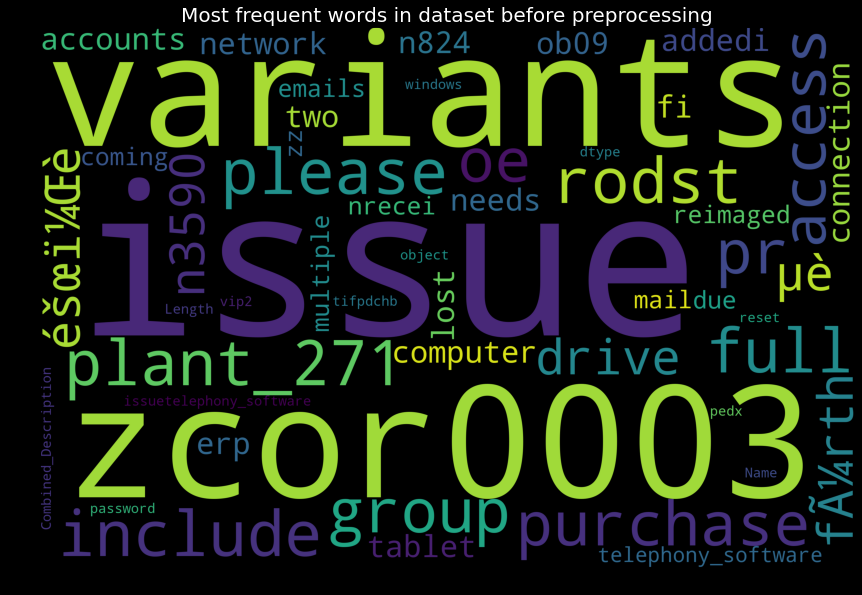

In [37]:
# define wordcloud function from wordcloud library. set some parameteres for beatuful plotting
wc = WordCloud(width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS)

# generate word cloud for data before preprocessing
wc_word=wc.generate(str(data_df.Combined_Description))
print(wc_word)

# declare our figure 
plt.figure(figsize=(20,10), facecolor='k')

# add title to the graph
plt.title("Most frequent words in dataset before preprocessing", fontsize=20,color='white')
plt.imshow(wc_word)
plt.show()

## Data Pre-processing

- Handling of missing Records
- Handling of special characters
- Handling of contractions text
- Handling of URL, IP address, numbers
- Handling of multilingual text
- Handling of whitespace/newline
- Handling of stopwords
- Identification of maxlen and minlen


In [0]:
#function to preprocess data 
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence = contractions.fix(sentence)
    sentence = sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_email = re.sub('\S+@+\S+[.com]','',cleantext)
    rem_special = re.sub(r'[_"\-;%()|~^+&=*%.,!?:#$@\[\]/]', ' ', rem_email)    
    rem_url=re.sub(r'http\S+', '',rem_special)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    # filtered_words = [w for w in tokens if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

In [0]:
# Run preprocessing for combined description data set
cleaner_Description = []
for combinedDescription in data_df.Combined_Description:
    cleaner_Description.append(preprocess(combinedDescription))

### Word Cloud after data processing

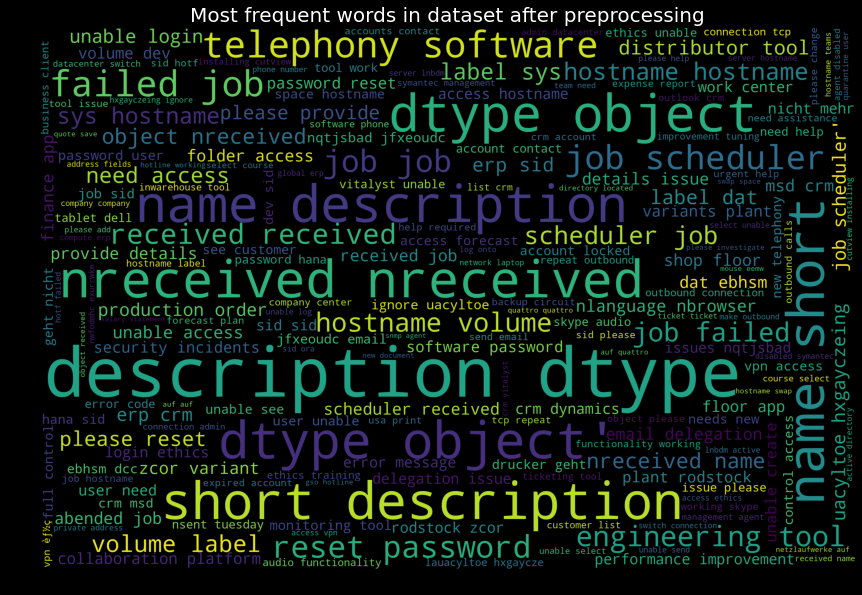

In [40]:
# define wordcloud function from wordcloud library. set some parameteres for beatuful plotting
wc = WordCloud(width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS)

# generate word cloud for preprocessed data
wc_word=wc.generate(str(cleaner_Description))
print(wc_word)

# declare our figure 
plt.figure(figsize=(20,10), facecolor='k')

# add title to the graph
plt.title("Most frequent words in dataset after preprocessing", fontsize=20,color='white')
plt.imshow(wc_word)
plt.show()

# Get the Length of each line and find min and max length

In [41]:
# Display the Maximum word count length in the new corpus

combined_description_maxlen = max([len(x.split()) for x in cleaner_Description])
print("Max length of words in the data is : ",combined_description_maxlen)

Max length of words in the data is :  767


Combined_Description length: 
Mean 321.93 words (303.919435)


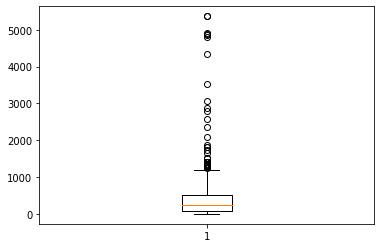

In [42]:
# Summarize Combined_Description length
print("Combined_Description length: ")
# result = [len(x) for x in data_df.Combined_Description]
result = [len(x) for x in cleaner_Description]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
plt.boxplot(result)
plt.show()

In [0]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
y = label_encoder.fit_transform(data_df.Assignment_group)

X = cleaner_Description

## Strategy for Maxlen

- The word count ranges between 800 to 10
- The Word count for majority of data samples is below 300
- After analyzing the word count, considered a max sequence length 150
- tested the model between 250 to 100 for max length

# Modelling

In [0]:
# Split the data set into Train and test
# Use Random_state to keep the train and test split consistant

X = np.array(cleaner_Description)
X_train, X_test, y_train, y_test = train_test_split(X, data_df['Assignment_group'].values,test_size=0.20, random_state=1)

# Model Building

- Naïve Bayes (Multinomial) Classifier
- SVM (Support Vector Machine) Classifier
- KNN (K-Nearest Neighbours) Classifier
- Logistic Regression Classifier
- Ensemble Algorithm - Decision Trees
- Word2Vec & Logistic Classifiers
- Linear Dense Networks 
- LSTM & Bidirectional LSTM


## TF_IDF Vectorizer

In [45]:
# Initialize TF-IDF Vectorizer
# Fit the TF-IDF Vectorizer on the Train data set

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [46]:
# Derive X Train and test data by applying vectorizer

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_train, X_test

(<11969x11571 sparse matrix of type '<class 'numpy.float64'>'
 	with 133273 stored elements in Compressed Sparse Row format>,
 <2993x11571 sparse matrix of type '<class 'numpy.float64'>'
 	with 32445 stored elements in Compressed Sparse Row format>)

In [47]:
from sklearn.feature_selection import SelectKBest, chi2

ch2 = SelectKBest(chi2, k=5000)
X_train = ch2.fit_transform(X_train, y_train)
X_test = ch2.transform(X_test)

X_train, X_test

(<11969x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 119359 stored elements in Compressed Sparse Row format>,
 <2993x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 29974 stored elements in Compressed Sparse Row format>)

# Logistic Regression Classifier

- Logistic regression is one of the most fundamental and widely used Machine Learning Algorithms. 
- Logistic regression is usually among the first few topics which people pick while learning predictive modeling. Logistic regression is not a regression algorithm but a probabilistic classification model
- Multiclass classification with logistic regression can be done either through the one-vs-rest scheme in which for each class a binary classification problem of data belonging or not to that class is done, or changing the loss function to cross- entropy loss.
- Logistic Regressor uses Sigmoid function

In [48]:
model = LogisticRegression()
model.fit(X_train, y_train)

%time

y_predict = model.predict(X_test)

# how did our model perform?
count_misclassified = (y_test != y_predict).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_predict)
print('Accuracy: {:.2f}'.format(accuracy))

#Predicting model score and Confusion matrix
test_model_score = model.score(X_test, y_test)
train_model_score = model.score(X_train, y_train)

print("\nTest Accuracy ", test_model_score)
print("\nTrain Accuracy", train_model_score)

CPU times: user 69 µs, sys: 127 µs, total: 196 µs
Wall time: 9.3 µs
Misclassified samples: 577
Accuracy: 0.81

Test Accuracy  0.8072168392916806

Train Accuracy 0.8328181134597711


In [49]:
print(metrics.confusion_matrix(y_test, y_predict))

[[804   0   0 ...   0   1   0]
 [  2  40   0 ...   0   0   0]
 [ 10   0  10 ...   0   5   0]
 ...
 [  2   0   0 ...   0   0   0]
 [  3   1   1 ...   0 112   1]
 [ 12   0   0 ...   0  39   4]]


In [50]:
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       GRP_0       0.69      0.98      0.81       820
       GRP_1       0.89      0.95      0.92        42
      GRP_10       0.91      0.37      0.53        27
      GRP_11       0.96      0.92      0.94        51
      GRP_12       0.69      0.41      0.51        49
      GRP_13       0.54      0.27      0.36        26
      GRP_14       0.50      0.08      0.14        24
      GRP_15       0.96      0.96      0.96        56
      GRP_16       0.00      0.00      0.00        19
      GRP_17       0.94      0.83      0.88        18
      GRP_18       0.00      0.00      0.00        12
      GRP_19       0.80      0.16      0.27        49
       GRP_2       0.91      0.42      0.57        48
      GRP_20       0.91      0.96      0.94        55
      GRP_21       1.00      0.90      0.95        50
      GRP_22       1.00      0.96      0.98        52
      GRP_23       0.97      1.00      0.99        34
      GRP_24       0.94    

### Applying Multinomial Naive Bayes

In [51]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
model = MultinomialNB()
model.fit(X_train, y_train)

%time

y_predict = model.predict(X_test)
#Predicting model score and Confusion matrix
test_model_score = model.score(X_test, y_test)
train_model_score = model.score(X_train, y_train)

print("\nTest Accuracy ", test_model_score)
print("\nTrain Accuracy", train_model_score)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs

Test Accuracy  0.5512863347811561

Train Accuracy 0.5875177541983457


In [52]:
print(metrics.confusion_matrix(y_test, y_predict))

[[818   0   0 ...   0   1   0]
 [  6  27   0 ...   0   7   0]
 [ 12   0   0 ...   0  15   0]
 ...
 [  2   0   0 ...   0   0   0]
 [ 12   0   0 ...   0 112   0]
 [ 15   0   0 ...   0  42   0]]


In [53]:
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       GRP_0       0.42      1.00      0.59       820
       GRP_1       0.82      0.64      0.72        42
      GRP_10       0.00      0.00      0.00        27
      GRP_11       1.00      0.12      0.21        51
      GRP_12       0.69      0.22      0.34        49
      GRP_13       0.00      0.00      0.00        26
      GRP_14       1.00      0.04      0.08        24
      GRP_15       1.00      0.50      0.67        56
      GRP_16       0.00      0.00      0.00        19
      GRP_17       0.00      0.00      0.00        18
      GRP_18       0.00      0.00      0.00        12
      GRP_19       0.00      0.00      0.00        49
       GRP_2       0.75      0.06      0.12        48
      GRP_20       1.00      0.40      0.57        55
      GRP_21       1.00      0.44      0.61        50
      GRP_22       1.00      0.42      0.59        52
      GRP_23       1.00      0.44      0.61        34
      GRP_24       1.00    

### Applying Bernoulli Naive Bayes

In [54]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
model = BernoulliNB()
model.fit(X_train, y_train)

%time

y_predict = model.predict(X_test)
test_model_score = model.score(X_test, y_test)
train_model_score = model.score(X_train, y_train)

print("\nTest Accuracy ", test_model_score)
print("\nTrain Accuracy", train_model_score)

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.44 µs

Test Accuracy  0.55462746408286

Train Accuracy 0.5743169855459939


In [55]:
print(metrics.confusion_matrix(y_test, y_predict))

[[813   0   0 ...   0   0   0]
 [  0  31   0 ...   0   0   0]
 [ 10   0   0 ...   0  15   0]
 ...
 [  0   0   0 ...   0   0   0]
 [ 13   0   0 ...   0 111   0]
 [ 12   0   0 ...   0  42   1]]


In [56]:
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       GRP_0       0.67      0.99      0.80       820
       GRP_1       0.79      0.74      0.77        42
      GRP_10       0.00      0.00      0.00        27
      GRP_11       1.00      0.12      0.21        51
      GRP_12       0.77      0.20      0.32        49
      GRP_13       0.33      0.08      0.12        26
      GRP_14       1.00      0.04      0.08        24
      GRP_15       0.97      0.59      0.73        56
      GRP_16       0.00      0.00      0.00        19
      GRP_17       0.00      0.00      0.00        18
      GRP_18       1.00      0.08      0.15        12
      GRP_19       0.50      0.04      0.08        49
       GRP_2       0.59      0.27      0.37        48
      GRP_20       1.00      0.45      0.62        55
      GRP_21       1.00      0.44      0.61        50
      GRP_22       1.00      0.35      0.51        52
      GRP_23       1.00      0.12      0.21        34
      GRP_24       0.64    

### Applying K-Nearest Neighbours

- KNN or k-nearest neighbours is the simplest classification algorithm. - This classification algorithm does not depend on the structure of the data. 
- Whenever a new example is encountered, its k nearest neighbours from the training data are examined. 
- Distance between two examples can be the euclidean distance between their feature vectors.
- Parameters used Neighbors =3 and weights = distance

In [57]:
model = KNeighborsClassifier(n_neighbors=3 , weights = 'distance' )
model.fit(X_train, y_train)

%time

y_predict = model.predict(X_test)
test_model_score = model.score(X_test, y_test)
train_model_score = model.score(X_train, y_train)

print("\nTest Accuracy ", test_model_score)
print("\nTrain Accuracy", train_model_score)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.96 µs

Test Accuracy  0.8259271633812229

Train Accuracy 0.9621522265853455


In [58]:
print(metrics.confusion_matrix(y_test, y_predict))

[[805   0   0 ...   0   1   0]
 [  0  42   0 ...   0   0   0]
 [ 12   0  10 ...   0   2   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  6   0   3 ...   0  75   5]
 [ 13   0   3 ...   0   5   7]]


In [59]:
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       GRP_0       0.70      0.98      0.81       820
       GRP_1       0.98      1.00      0.99        42
      GRP_10       0.56      0.37      0.44        27
      GRP_11       1.00      0.92      0.96        51
      GRP_12       0.93      0.27      0.41        49
      GRP_13       1.00      0.12      0.21        26
      GRP_14       0.75      0.25      0.38        24
      GRP_15       0.98      1.00      0.99        56
      GRP_16       0.00      0.00      0.00        19
      GRP_17       1.00      0.39      0.56        18
      GRP_18       0.00      0.00      0.00        12
      GRP_19       1.00      0.06      0.12        49
       GRP_2       0.80      0.33      0.47        48
      GRP_20       0.96      1.00      0.98        55
      GRP_21       1.00      1.00      1.00        50
      GRP_22       1.00      1.00      1.00        52
      GRP_23       0.97      1.00      0.99        34
      GRP_24       0.90    

### Applying Support Vector machines

- Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.
- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.
- Implement the “one-versus-one” approach for multi-class classification.
- Parameters C=3 and gamma = 0.025

In [60]:
model = svm.SVC(gamma=0.025, C=3)
model.fit(X_train, y_train)

%time

y_predict = model.predict(X_test)
test_model_score = model.score(X_test, y_test)
train_model_score = model.score(X_train, y_train)

print("\nTest Accuracy ", test_model_score)
print("\nTrain Accuracy", train_model_score)

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 5.96 µs

Test Accuracy  0.6024056130972268

Train Accuracy 0.6538557941348484


In [61]:
print(metrics.confusion_matrix(y_test, y_predict))

[[803   0   0 ...   0   0   0]
 [ 10  31   0 ...   0   1   0]
 [ 12   0  10 ...   0   5   0]
 ...
 [  2   0   0 ...   0   0   0]
 [ 10   1   1 ...   0 109   0]
 [ 15   0   0 ...   0  42   0]]


In [62]:
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       GRP_0       0.46      0.98      0.62       820
       GRP_1       0.94      0.74      0.83        42
      GRP_10       0.91      0.37      0.53        27
      GRP_11       1.00      0.24      0.38        51
      GRP_12       0.54      0.31      0.39        49
      GRP_13       1.00      0.08      0.14        26
      GRP_14       1.00      0.04      0.08        24
      GRP_15       0.94      0.61      0.74        56
      GRP_16       0.00      0.00      0.00        19
      GRP_17       0.93      0.72      0.81        18
      GRP_18       0.00      0.00      0.00        12
      GRP_19       0.00      0.00      0.00        49
       GRP_2       0.00      0.00      0.00        48
      GRP_20       1.00      0.38      0.55        55
      GRP_21       1.00      0.60      0.75        50
      GRP_22       0.89      0.63      0.74        52
      GRP_23       0.89      1.00      0.94        34
      GRP_24       0.95    

### Applying DecisionTreeClassifier

- Decision tree classifier is a systematic approach for multiclass classification. 
- It poses a set of questions to the dataset (related to its attributes/features). 
- The decision tree classification algorithm can be visualized on a binary tree. 
- On the root and each of the internal nodes, a question is posed and the data on that node is further split into separate records that have different characteristics.
- Parameters used criterion = Gini

In [63]:
model = DecisionTreeClassifier(criterion = 'gini', random_state=1)
model.fit(X_train, y_train)

%time

y_predict = model.predict(X_test)
test_model_score = model.score(X_test, y_test)
train_model_score = model.score(X_train, y_train)
print("\nTest Accuracy ", test_model_score)
print("\nTrain Accuracy", train_model_score)

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 6.44 µs

Test Accuracy  0.8309388573337788

Train Accuracy 0.972178126827638


In [64]:
print(metrics.confusion_matrix(y_test, y_predict))

[[710   0   1 ...   0   7   2]
 [  0  42   0 ...   0   0   0]
 [  4   0  11 ...   0   6   1]
 ...
 [  0   0   0 ...   2   0   0]
 [  2   0   1 ...   0 107   1]
 [ 10   0   1 ...   0  35   4]]


In [65]:
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       GRP_0       0.82      0.87      0.84       820
       GRP_1       1.00      1.00      1.00        42
      GRP_10       0.55      0.41      0.47        27
      GRP_11       1.00      0.92      0.96        51
      GRP_12       0.57      0.53      0.55        49
      GRP_13       0.38      0.42      0.40        26
      GRP_14       0.36      0.21      0.26        24
      GRP_15       1.00      1.00      1.00        56
      GRP_16       0.47      0.47      0.47        19
      GRP_17       1.00      0.94      0.97        18
      GRP_18       0.17      0.17      0.17        12
      GRP_19       0.21      0.14      0.17        49
       GRP_2       0.43      0.40      0.41        48
      GRP_20       1.00      1.00      1.00        55
      GRP_21       0.98      1.00      0.99        50
      GRP_22       1.00      1.00      1.00        52
      GRP_23       1.00      1.00      1.00        34
      GRP_24       0.81    

# RNN (Recurrent Nearal Networks)



### Set Different Parameters for the model

In [0]:
# define hyper parameters for the Neural Networks
# Maximum number of words in the corpus - max_features
# Max Length for each sequence and will be used for padding
# Embedding Dimension Size for the Model

max_features = 10000
# maxlen = combined_description_maxlen
maxlen = 150
embedding_size = 200

In [0]:
# Split the train and test data set by 80:20 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
# Convert the groups to categorical values

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Apply Keras Tokenizer for the data

In [0]:
# Use Tokenizer to convert the text to sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


### Define X and y for your model

In [0]:
# Apply padding

vocab_size = len(tokenizer.word_index) + 1

MAX_SEQUENCE_LENGTH = maxlen

X_train = pad_sequences(X_train, padding='pre', maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, padding='pre', maxlen=MAX_SEQUENCE_LENGTH)

## Define CallBacks

In [0]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
    

def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Modeling

### Cyclic Learning Rate (CLR)

Instead of monotonically decreasing our learning rate, we instead:

- Define the lower bound on our learning rate (called “base_lr”).
- Define the upper bound on the learning rate (called the “max_lr”).
- Allow the learning rate to oscillate back and forth between these two bounds when training, slowly increasing and decreasing the learning rate after every batch update.

![alt text](https://pyimagesearch.com/wp-content/uploads/2019/07/keras_clr_triangular.png)

In [0]:
base_lr = 1e-7
max_lr = 1e-2
BATCH_SIZE = 64
step_size = 200
mode = "triangular"
NUM_EPOCHS = 96

clr = CyclicLR(base_lr=0.001, max_lr=0.007,
# clr = CyclicLR(base_lr=base_lr, max_lr=max_lr,
                        step_size=200., mode='triangular',
                        gamma=0.99994)

In [73]:
# define the number of classes from y variable
# N_CLASSES = np.unique(y).size
N_CLASSES = data_df['Assignment_group'].value_counts().count()
print("Unique classes are : ", N_CLASSES)

Unique classes are :  74


### Most commonly used optimization algorithms because of their generally better performance are:

- Stochastic Gradient Descent, or ‘sgd‘, that requires the tuning of a learning rate and momentum.
- ADAM, or ‘adam‘, that requires the tuning of learning rate.
- RMSprop, or ‘rmsprop‘, that requires the tuning of learning rate.

In [74]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            embedding_size,
                            input_length=MAX_SEQUENCE_LENGTH)(inputs)
print(embedding_layer)                            
# y = SpatialDropout1D(0.2)(embedding_layer)
# print(y)
x = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(embedding_layer)
print(x)
x = Bidirectional(LSTM(128))(x)
print(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(N_CLASSES, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

print(model.summary())

Tensor("embedding/Identity:0", shape=(None, 150, 200), dtype=float32)
Tensor("bidirectional/Identity:0", shape=(None, 150, 256), dtype=float32)
Tensor("bidirectional_1/Identity:0", shape=(None, 256), dtype=float32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 200)          2359800   
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 256)          336896    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 100)               25700     
____________________________________________

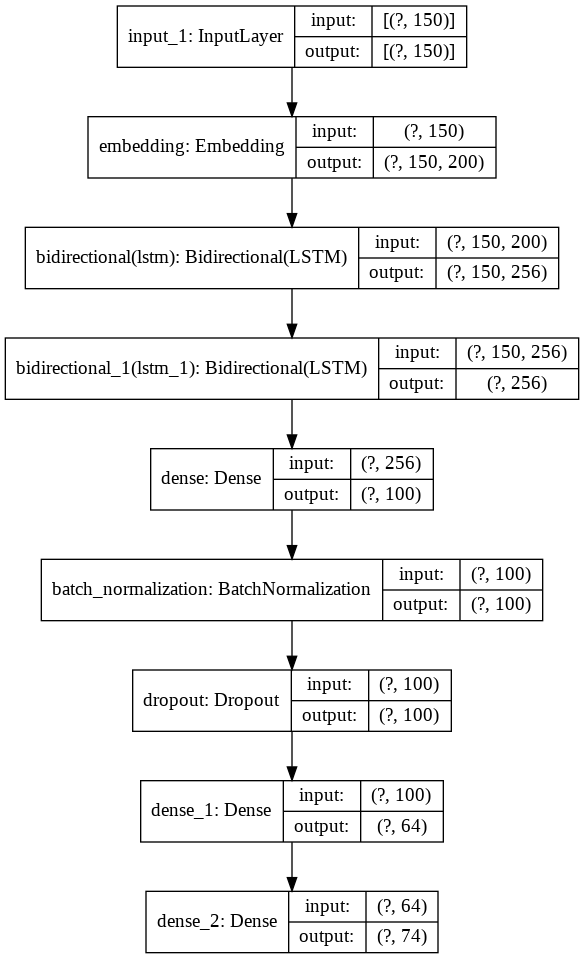

In [75]:
from tensorflow.keras.utils import  plot_model
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

# Model Evaluation

In [76]:
batch_size = 64
epochs = 15

# Fit the model
history = model.fit(X_train, y_train, batch_size, epochs, verbose=1, validation_data=(X_test, y_test), callbacks = [clr])

Epoch 1/15
188/188 [==============================] - 225s 1s/step - loss: 2.4849 - acc: 0.3713 - val_loss: 2.2094 - val_acc: 0.4323
Epoch 2/15
188/188 [==============================] - 222s 1s/step - loss: 1.5165 - acc: 0.5659 - val_loss: 1.1423 - val_acc: 0.6709
Epoch 3/15
188/188 [==============================] - 218s 1s/step - loss: 0.9118 - acc: 0.7316 - val_loss: 1.3210 - val_acc: 0.6492
Epoch 4/15
188/188 [==============================] - 219s 1s/step - loss: 0.8688 - acc: 0.7363 - val_loss: 0.8713 - val_acc: 0.7665
Epoch 5/15
188/188 [==============================] - 219s 1s/step - loss: 0.4649 - acc: 0.8552 - val_loss: 0.9079 - val_acc: 0.7604
Epoch 6/15
188/188 [==============================] - 218s 1s/step - loss: 0.5634 - acc: 0.8263 - val_loss: 0.9788 - val_acc: 0.8005
Epoch 7/15
188/188 [==============================] - 219s 1s/step - loss: 0.3298 - acc: 0.8894 - val_loss: 0.8439 - val_acc: 0.8119
Epoch 8/15
188/188 [==============================] - 219s 1s/step - 

In [77]:
# Final evaluation of the model

%time

score,acc = model.evaluate(X_test, y_test, verbose=1)
print("Score: %.2f" % (score))
print("Accuracy: %.2f%%" % (acc*100))

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.54 µs
94/94 [==============================] - 17s 183ms/step - loss: 0.9287 - acc: 0.8202
Score: 0.93
Accuracy: 82.02%


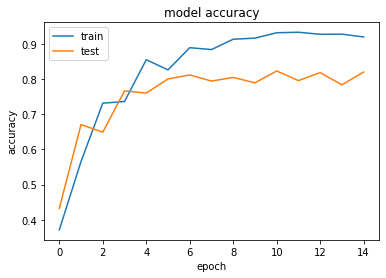

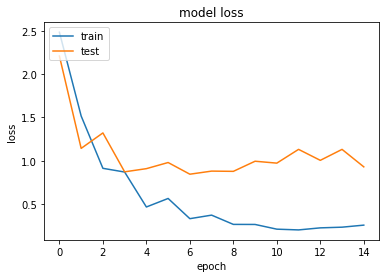

In [78]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [0]:
h = clr.history
lr = h['lr']
acc = h['acc']

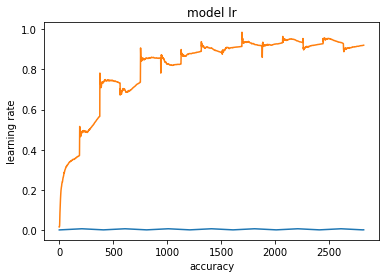

In [80]:
plt.plot(lr)
plt.plot(acc)

plt.title('model lr')
plt.ylabel('learning rate')
plt.xlabel('accuracy')
# plt.legend(['train','test'], loc='upper left')
plt.show()

In [81]:
from sklearn.metrics import classification_report, confusion_matrix

# evaluate the network and show a classification report
print("Evaluating network...")
predictions = model.predict(X_test, batch_size=batch_size)
print(confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1)))
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

Evaluating network...
[[657   0   3 ...   0   2   5]
 [  0  49   0 ...   0   0   0]
 [  2   0  12 ...   0   6   1]
 ...
 [  0   0   0 ...   0   0   0]
 [  1   0   0 ...   0 111   0]
 [  6   0   0 ...   0  40   5]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       767
           1       1.00      1.00      1.00        49
           2       0.60      0.39      0.47        31
           3       0.88      1.00      0.94        37
           4       0.64      0.54      0.59        59
           5       0.36      0.33      0.34        30
           6       0.37      0.29      0.33        24
           7       0.94      0.98      0.96        64
           8       0.15      0.17      0.16        12
           9       0.84      0.94      0.89        17
          10       0.29      0.37      0.33        19
          11       0.29      0.28      0.28        54
          12       0.36      0.38      0.37        42
          13       1.00      

# Summary

### We have tried various models as below,
- Naive Bias
- KNN
- SVM
- Decision Trees
- Logistic Classifier
- LSTM

# Summary of Model performance


In [84]:
model_results = pd.DataFrame([('Logistic Regression Classifier', 83.29, 80.72, 7.87),
                  ('Multinomial Naive Bayes',58.75, 55.12, 4.77), 
                  ('K Nearest Neighour', 96.21, 82.59, 8.11),
                  ('Support Vector Machine', 65.38, 60.24, 5.25),
                  ('Decision Trees Classifier', 97.21, 83.09, 5.01),
                  ('LSTM', 97.21, 82.09, 6.44)],
                  columns=('Model Name', 'Train Accuracy','Test Accuracy', 'Time (micro second)'))

model_results

,Model Name,Train Accuracy,Test Accuracy,Time (micro second)
0,Logistic Regression Classifier,83.29,80.72,7.87
1,Multinomial Naive Bayes,58.75,55.12,4.77
2,K Nearest Neighour,96.21,82.59,8.11
3,Support Vector Machine,65.38,60.24,5.25
4,Decision Trees Classifier,97.21,83.09,5.01
5,LSTM,97.21,83.09,6.44


- The final solution will reduce the time spent by L1 or L2 teams to re-route the incidents to proper assignment groups automatically
- The solution will help to save the number of hours spent by resources on the manual activities of re-assigning to the appropriate group and hence the saved time can be spent on other productive activities
- Minimizes the Human errors in identifies the appropriate groups
- Time saved is directly proportional to the dollars saved and hence better operating margin
- Also inspires the organizations to utilise the AI technology for various other such human driven activities
